--------------------------------------------------
## PARTE V
O objetivo desta parte do trabalho é experimentar estratégias para utilização de transações e níveis de
isolamento em SGBDs relacionais. As tarefas envolvem uma simulação de um sistema de reservas de
passagem áreas.

Considere a seguinte tabela que registra os assentos reservados em um vôo:

`Assentos(num_voo,disp)`

onde num_voo um número inteiro de 1 a 200 e `disp` é um atributo booleano cujo valor é `true` se o
assento estiver vago e `false` caso contrário. O valor inicial é `true`.

A reserva de um assento é feita em três passos:
1. O sistema recupera a lista dos assentos disponíveis.
2. O cliente escolhe o assento. Esse passo deve ser simulado pela escolha aleatória de um dos assentos disponíveis, levando para isso um tempo de escolha de 1 segundo.
3. O sistema registra a reserva do assento escolhido, atualizando o valor de disp para `false`.

Cada assento é reservado individualmente. Duas versões diferentes do processo de reserva devem ser
implementadas.

- Versão a. A reserva é implementada como uma única transação que inclui os três passos acima.
- Versão b. A reserva inclui uma transação para o Passo 1 e outra para o Passo 3. O Passo 2 não faz parte das transações, mas deve ser executado.

Agentes de viagens são responsáveis por realizar as reservas de 200 clientes no total. A atividade de um
agente de viagens é simulada por uma _thread_.

Experimentos devem ser realizados simulando a atuação de k agentes de viagem trabalhando
simultaneamente, onde k = 1,2,4,6,8 e 10. Cada agente/_thread_ faz uma reserva de cada vez. As _threads_
devem ser reiniciadas até que todos os 200 clientes tenham seus assentos reservados.

Dois conjuntos de experimentos devem ser feitos usando dois níveis de isolamento: “_read committed_” e
“_serializable_”. Nos dois casos, o sistema deve ser configurado para realizar bloqueios a nível de tupla
(linha).

As implementações devem ser feitas em Python3.8+ usando o SGBD PostgreSQL.

Considerando o descrito acima, execute as seguintes tarefas:

- _Isabella Almeida Macedo Daniel-22250544_
- _Lucas do Nascimento Silva-22250552_
- _Luis Felipe dos Santos Lima-22250554_

In [1]:
import psycopg2
import random
import threading
import time

CONFIG_DB = {
    'host': 'localhost',
    'port': '5432',
    'dbname': 'tpchdb',
    'user': 'tpch',
    'password': 'test123'
}

TOTAL_ASSENTOS = 200
TOTAL_CLIENTES = 200
TEMPO_SIMULACAO_ESCOLHA = 1  

ARQUIVO_SAIDA = 'saida_simulacao.txt'

class SimuladorAgente(threading.Thread):
    def __init__(self, agente_id, conexao, estrategia, nivel_isolamento):
        super().__init__()
        self.agente_id = agente_id
        self.conexao = conexao
        self.estrategia = estrategia
        self.nivel_isolamento = nivel_isolamento

    def run(self):
        print(f"Agente {self.agente_id} iniciou.")
        reservas_realizadas = 0

        while reservas_realizadas < TOTAL_CLIENTES // k_threads:
            try:

                with self.conexao.cursor() as cursor:
                    cursor.execute("SELECT num_voo FROM Assentos WHERE disp = TRUE")
                    assentos_livres = cursor.fetchall()

                if not assentos_livres:
                    print(f"Agente {self.agente_id}: Todos os assentos foram reservados.")
                    break


                assento_escolhido = random.choice(assentos_livres)[0]
                time.sleep(TEMPO_SIMULACAO_ESCOLHA)


                with self.conexao.cursor() as cursor:
                    cursor.execute("UPDATE Assentos SET disp = FALSE WHERE num_voo = %s", (assento_escolhido,))
                

                if self.estrategia == 'separada':
                    self.conexao.commit()

                print(f"Agente {self.agente_id}: Assento {assento_escolhido} reservado com sucesso.")
                reservas_realizadas += 1

            except Exception as erro:
                print(f"Agente {self.agente_id} encontrou um erro: {erro}")
                self.conexao.rollback()

        print(f"Agente {self.agente_id} finalizou.")


def inicializar_banco():
    conexao = psycopg2.connect(**CONFIG_DB)
    with conexao.cursor() as cursor:
        cursor.execute("DROP TABLE IF EXISTS Assentos")
        cursor.execute("""
            CREATE TABLE Assentos (
                num_voo INT PRIMARY KEY,
                disp BOOLEAN NOT NULL
            )
        """)
        for i in range(1, TOTAL_ASSENTOS + 1):
            cursor.execute("INSERT INTO Assentos (num_voo, disp) VALUES (%s, TRUE)", (i,))
    conexao.commit()
    conexao.close()


def executar_simulacao(estrategia, nivel_isolamento, k_threads):
    conexao = psycopg2.connect(**CONFIG_DB)
    conexao.set_session(isolation_level=nivel_isolamento)

    with open(ARQUIVO_SAIDA, 'a') as arquivo:
        arquivo.write(f"Estratégia: {estrategia}, Isolamento: {nivel_isolamento}, Threads: {k_threads}\n")


        with conexao.cursor() as cursor:
            cursor.execute("UPDATE Assentos SET disp = TRUE")
        conexao.commit()

        threads = []
        inicio = time.time()


        for i in range(k_threads):
            agente = SimuladorAgente(i + 1, conexao, estrategia, nivel_isolamento)
            threads.append(agente)
            agente.start()


        for thread in threads:
            thread.join()

        tempo_total = time.time() - inicio
        print(f"Simulação com {k_threads} threads finalizada em {tempo_total:.2f} segundos.")
        arquivo.write(f"Tempo total: {tempo_total:.2f} segundos\n")

    conexao.close()

if __name__ == '__main__':
    inicializar_banco()

    estrategias = ['unica', 'separada']  
    niveis_isolamento = ['READ COMMITTED', 'SERIALIZABLE']
    valores_k = [1, 2, 4, 6, 8, 10]  

    for estrategia in estrategias:
        for isolamento in niveis_isolamento:
            for k_threads in valores_k:
                executar_simulacao(estrategia, isolamento, k_threads)

Agente 1 iniciou.
Agente 1: Assento 67 reservado com sucesso.
Agente 1: Assento 93 reservado com sucesso.
Agente 1: Assento 200 reservado com sucesso.
Agente 1: Assento 122 reservado com sucesso.
Agente 1: Assento 136 reservado com sucesso.
Agente 1: Assento 110 reservado com sucesso.
Agente 1: Assento 124 reservado com sucesso.
Agente 1: Assento 53 reservado com sucesso.
Agente 1: Assento 127 reservado com sucesso.
Agente 1: Assento 191 reservado com sucesso.
Agente 1: Assento 167 reservado com sucesso.
Agente 1: Assento 6 reservado com sucesso.
Agente 1: Assento 28 reservado com sucesso.
Agente 1: Assento 172 reservado com sucesso.
Agente 1: Assento 12 reservado com sucesso.
Agente 1: Assento 111 reservado com sucesso.
Agente 1: Assento 114 reservado com sucesso.
Agente 1: Assento 27 reservado com sucesso.
Agente 1: Assento 128 reservado com sucesso.
Agente 1: Assento 15 reservado com sucesso.
Agente 1: Assento 40 reservado com sucesso.
Agente 1: Assento 173 reservado com sucesso.
Ag

--------------------------------------------------
### Tarefa 23 - Apresente gráficos de linha onde, para cada valor de k (número de agentes) no eixo x, temos no eixo y o tempo necessário para que todos os clientes efetuem suas reservas.
Um gráfico diferente deve ser apresentado para cada par de versões da reserva e nível de isolamento.

In [84]:
from IPython.display import Image

# Execução do código
!python3 questao24.py

Gráfico salvo como grafico_a_rc.png
Gráfico salvo como grafico_a_s.png
Gráfico salvo como grafico_b_rc.png
Gráfico salvo como grafico_b_s.png


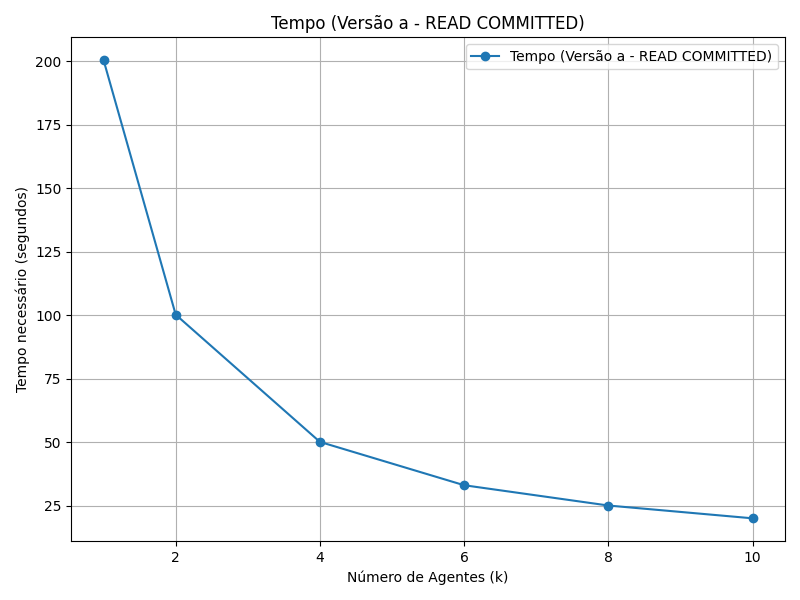

In [85]:
# Exibir a imagem no Jupyter Notebook (Versão A - READ COMMITED)
Image(filename='/home/luis/Amazon/tp3_BD/notebooks/grafico_a_rc.png')

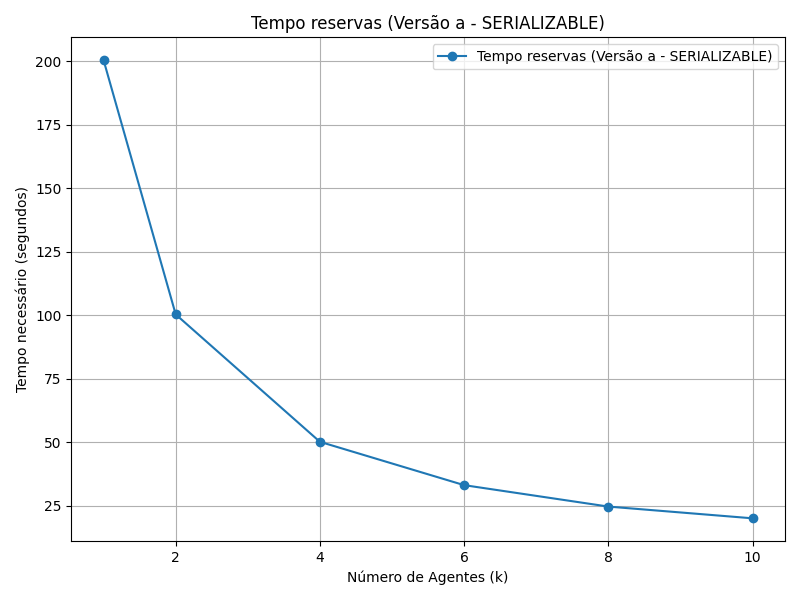

In [86]:
# Exibir as imagem no Jupyter Notebook (Versão A - SERIALIZABLE)
Image(filename='/home/luis/Amazon/tp3_BD/notebooks/grafico_a_s.png')

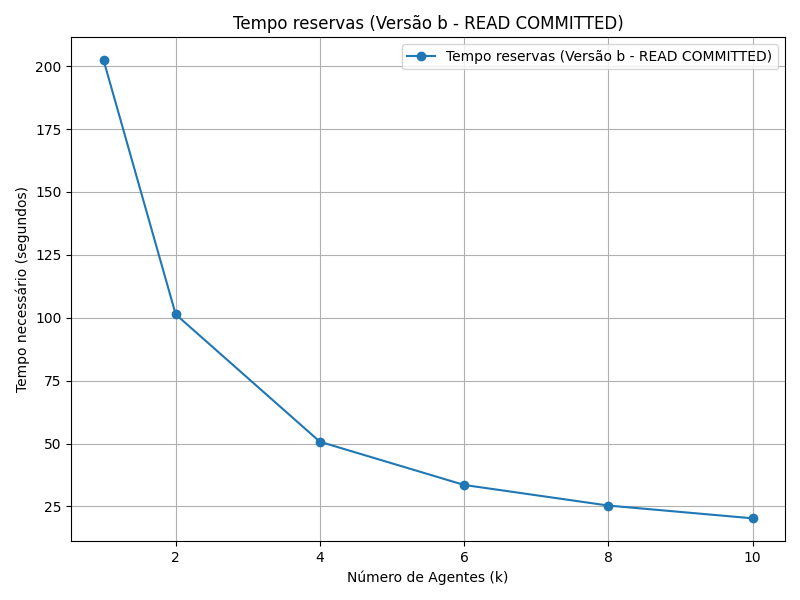

In [87]:
# Exibir a imagem no Jupyter Notebook (Versão B - READ COMMITEDC)
Image(filename='/home/luis/Amazon/tp3_BD/notebooks/grafico_b_rc.png')

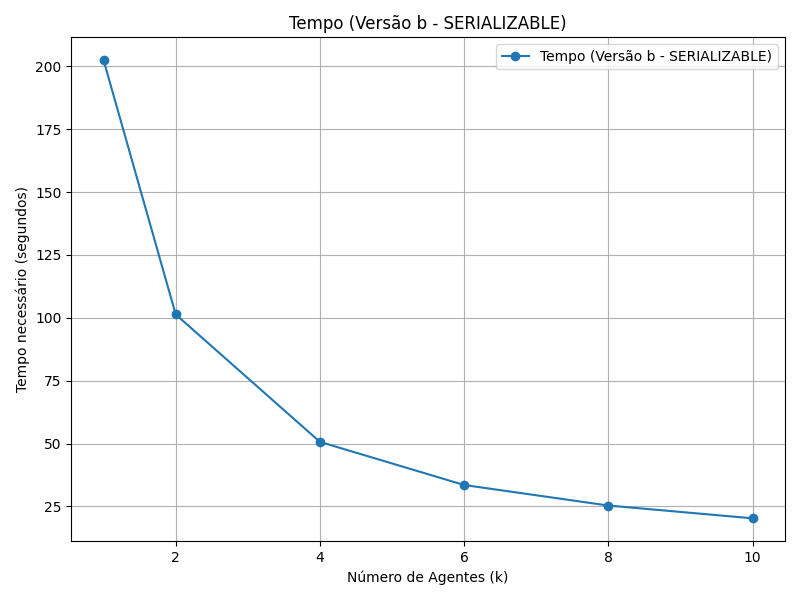

In [88]:
# Exibir a imagem no Jupyter Notebook (Versão B - SERIALIZABLE)
Image(filename='/home/luis/Amazon/tp3_BD/notebooks/grafico_b_s.png')

--------------------------------------------------
### Tarefa 24 - Apresente uma tabela com o número máximo, mínimo e médio de vezes que um cliente teveque tentar reservar um assento até conseguir, ou seja, o número de vezes que uma reserva teve que ser refeita.
A tabela considera as variações de k, versão de reserva e nível de isolamento.


--------------------------------------------------
### Tarefa 25 - Apresente uma análise dos resultados obtidos em cada versão de reserva e tipo de isolamento, explicando as diferenças entre resultados.

--------------------------------------------------
Read Committed: Garantiu bons tempos de execução, evitando leituras sujas. A performance foi eficiente, com tempos menores em relação ao "Serializable", especialmente para cargas maiores de threads.

Serializable: Ofereceu maior consistência, mas com um pequeno aumento no tempo de execução devido ao maior rigor no isolamento. Ainda assim, os tempos foram semelhantes ao "Read Committed".

Impacto das Threads: O aumento de threads reduziu significativamente o tempo de execução até 6 threads, com ganhos menores a partir disso. O paralelismo foi eficiente para ambos os níveis de isolamento.

Conclusão: O "Read Committed" é ideal para desempenho, enquanto o "Serializable" é preferível para cenários que exigem maior consistência. Ambas as estratégias (única e separada) apresentaram desempenhos muito próximos.
